In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [2]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(218 * 178 * 3, 100),
            nn.LeakyReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []
        self.loss_func = nn.BCELoss()

    def forward(self, inputs):
        return self.model(inputs.view(-1, 218 * 178 * 3))

    def nn_train(self, inputs, targets):
        outputs = self(inputs)
        loss = self.loss_func(outputs, targets)
        self.counter += 1
        if not self.counter % 10:
            self.progress.append(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(figsize=(16, 8), alpha=0.1, marker='.', grid=True)

In [3]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 300),
            nn.LeakyReLU(),
            nn.LayerNorm(300),
            nn.Linear(300, 218 * 178 * 3),
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs).view(-1, 3, 218, 178)

    def nn_train(self, discriminator: D, inputs, targets):
        g_outputs = self(inputs)
        d_outputs = discriminator(g_outputs)
        loss = discriminator.loss_func(d_outputs, targets)
        self.counter += 1
        if not self.counter % 10:
            self.progress.append(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(figsize=(16, 8), alpha=0.1, marker='.', grid=True)

    def plot_images(self):
        _, canvases = plt.subplots(2, 3)
        for i in range(2):
            for j in range(3):
                canvases[i][j].imshow(self(torch.randn(1, 100, device=device)).cpu().detach().numpy().reshape(28, 28), interpolation='none', cmap='Blues')

In [4]:
PATH_D = '../pth/GAN_CelebAD.pth'
PATH_G = '../pth/GAN_CelebAG.pth'

In [5]:
epoch = 1

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CelebA(root=r"../data", transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

In [7]:
d = D().to(device)
g = G().to(device)

In [8]:
try:
    d = torch.load(PATH_D, map_location=device)
    g = torch.load(PATH_G, map_location=device)
except FileNotFoundError:
    d = D().to(device)
    g = G().to(device)

In [39]:
%%time
for e in range(epoch):
    print(f'epcoh-{e + 1}...', end='')
    for step, (data, _) in enumerate(trainloader):
        data = data.to(device)
        size = data.size(0)
        d.nn_train(data, torch.ones(size, 1, device=device))
        d.nn_train(g(torch.randn(size, 100, device=device)), torch.zeros(size, 1, device=device))
        g.nn_train(d, torch.randn(size, 100, device=device), torch.ones(size, 1, device=device))
    print('finished')

epcoh-1...finished
CPU times: total: 1h 33min 12s
Wall time: 39min 44s


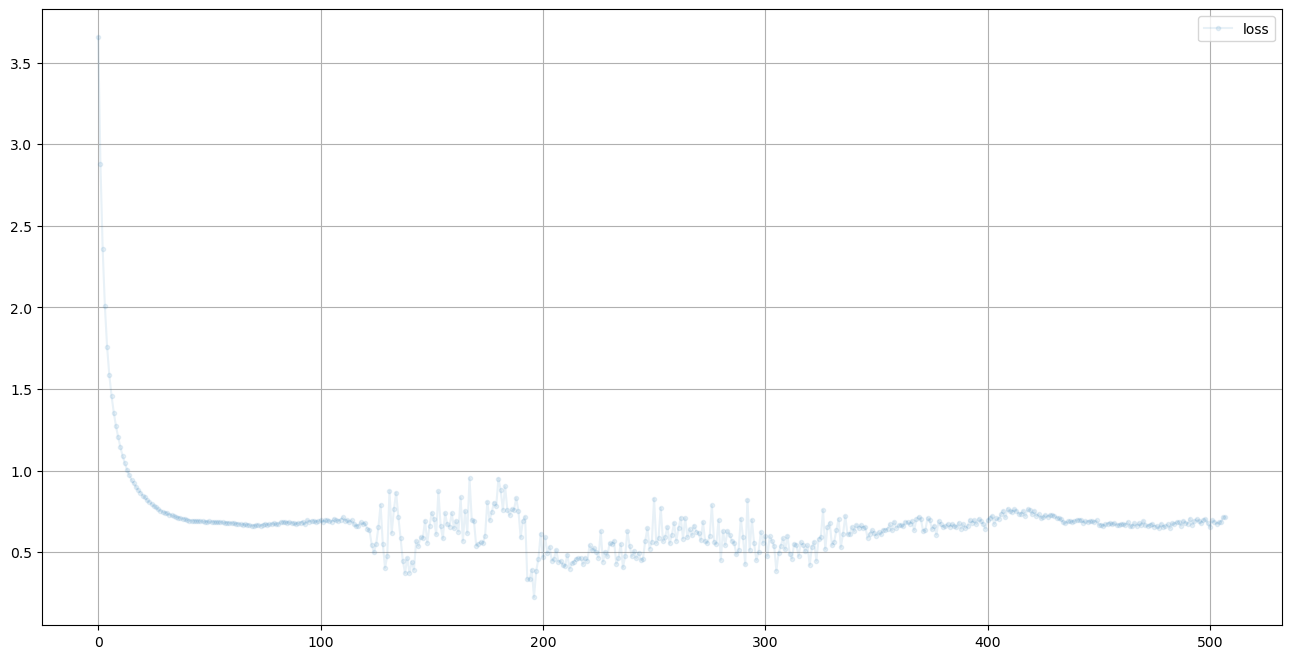

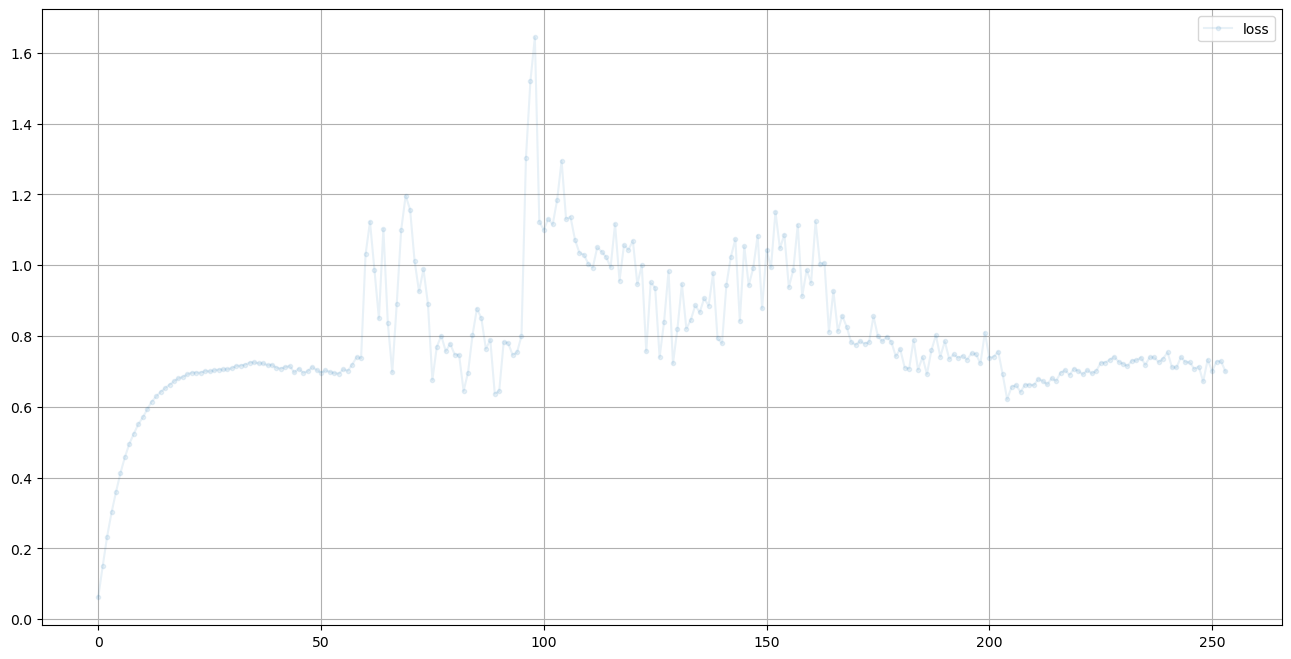

In [9]:
d.plot_progress()
g.plot_progress()

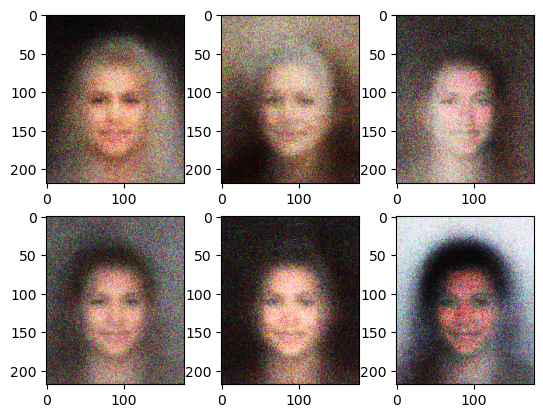

In [11]:
_, canvases = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        canvases[i][j].imshow(g(torch.randn(1, 100, device=device)).view(3, 218, 178).permute([1, 2, 0]).cpu().detach().numpy())